<a href="https://colab.research.google.com/github/FireMight/point-cloud-retrieval-from-image/blob/master/generate_pcl_submaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# First time
%cd /content
!git clone https://github.com/FireMight/point-cloud-retrieval-from-image.git
%cd /content/point-cloud-retrieval-from-image
!git submodule update --init --recursive
%cd ..

[Errno 2] No such file or directory: '/content'
/Users/marco/uni/semester_3/ADL4CV/point-cloud-retrieval-from-image
Cloning into 'point-cloud-retrieval-from-image'...
remote: Enumerating objects: 385, done.
remote: Counting objects: 100% (385/385), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 385 (delta 180), reused 345 (delta 152), pack-reused 0
Receiving objects: 100% (385/385), 14.23 MiB | 1.61 MiB/s, done.
Resolving deltas: 100% (180/180), done.
[Errno 2] No such file or directory: '/content/point-cloud-retrieval-from-image'
/Users/marco/uni/semester_3/ADL4CV/point-cloud-retrieval-from-image
/Users/marco/uni/semester_3/ADL4CV


In [1]:
# Pull repository
%cd /content/point-cloud-retrieval-from-image
!git pull --recurse-submodules
%cd ..

/content/point-cloud-retrieval-from-image
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/FireMight/point-cloud-retrieval-from-image
   2667a80..7302be0  master     -> origin/master
Fetching submodule netvlad
Fetching submodule pointnet
Updating 2667a80..7302be0
Fast-forward
 data/oxford/robotcar-dataset-sdk/python/build_pointcloud.py | 2 ++
 1 file changed, 2 insertions(+)
/content


In [22]:
import os
import csv
import sys
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
# For Google colab
from google.colab import drive
drive.mount('/content/drive')

sdk_dir = '/content/point-cloud-retrieval-from-image/data/oxford/robotcar-dataset-sdk'
project_dir = '/content/drive/My Drive/ADL4CV'

run_id = 'reference'
data_dir = project_dir + '/downloads/oxford_dataset/' + run_id
lms_dir = data_dir + '/lms_front'
lms_timestamps_file = data_dir + '/lms_front.timestamps'
gps_dir = data_dir + '/gps'
ins_data_file = gps_dir + '/ins.csv'
extrinsics_dir = sdk_dir + '/extrinsics'

In [9]:
# For local use
sdk_dir = 'data/oxford/robotcar-dataset-sdk'

run_id = 'reference'
data_dir = 'data/oxford/data/'  + run_id
lms_dir = data_dir + '/lms_front'
lms_timestamps_file = data_dir + '/lms_front.timestamps'
gps_dir = data_dir + '/gps'
vo_data_file = data_dir + '/vo/vo.csv'
ins_data_file = gps_dir + '/ins.csv'
extrinsics_dir = sdk_dir + '/extrinsics'

In [23]:
sys.path.insert(0, sdk_dir + '/python')
import build_pointcloud as sdk_pcl

class PointcloudLoader():
    def __init__(self):
        self.trajectory_ned = None
        self.pointcloud_ned = None
        self.subset_split = None
    
    def load_ned_trajectory(self, subset_split=None):
        # Get start and end timestamp of LIDAR measurements
        print('Get start and end time of LIADR measurements...')
        with open(lms_timestamps_file) as ts_file:
            start_time = int(next(ts_file).split(' ')[0])
            for end_time in ts_file:
                continue
            end_time = int(end_time.split(' ')[0])
        print('Done!')

        # Check if NED trajectory has already been computed
        trajectory_file = gps_dir + '/ned_trajectory_ins_{}.npy'.format(run_id)
        print('Search for precomputed NED trajectory ' + trajectory_file + '...')

        try:
            self.trajectory_ned = np.load(trajectory_file)
            print('Done!')
        except:
            # Get trajectory corresponding to LIDAR data
            print('Not found! Create NED trajectory from INS data...')
            self.trajectory_ned = np.empty((7,0))
            with open(ins_data_file, 'r') as ins_file:
                reader = csv.DictReader(ins_file)
                for row in reader:
                    if int(row['timestamp']) > end_time:
                        break
                    if int(row['timestamp']) < start_time:
                        continue
                    ned_state = np.array([float(row['northing']),
                                          float(row['easting']),
                                          float(row['down']),
                                          float(row['roll']),
                                          float(row['pitch']),
                                          float(row['yaw']),
                                          float(row['timestamp'])]).reshape(7,1)
                    self.trajectory_ned = np.append(self.trajectory_ned, 
                                                    ned_state, axis=1)
            print('Done! Trajectory with {} samples'.format(
                                                  self.trajectory_ned.shape[1]))

            # Save trajectory
            print('Save NED trajectory to ' + trajectory_file + '...')
            np.save(trajectory_file, self.trajectory_ned)
            print('Done!')
            
        # If specified, use only a subset of the data
        if subset_split is not None:
            max_idx = int(self.trajectory_ned.shape[1] * subset_split)
            print('WARNING: We use only the first {}% of the trajectory ({} measurements)'.
                                                format(int(subset_split*100), max_idx))
            self.trajectory_ned = self.trajectory_ned[:,:max_idx]
            self.subset_split = subset_split
            
    def load_ned_pointcloud(self):
        # Check if NED pointcloud has already been computed
        if self.subset_split is None:
            pointcloud_file = lms_dir + '/ned_pointcloud_{}.npy'.format(run_id)
        else:
            pointcloud_file = lms_dir + '/ned_pointcloud_{}_{}percent.npy'.format(
                                             run_id, int(self.subset_split*100))
        print('Search for precomputed NED pointcloud ' + pointcloud_file + '...')

        try:
            self.pointcloud_ned = np.load(pointcloud_file)
            print('Done!')
        except:
            # Construct pointcloud from lms measurements
            print('Not found! Create pointcloud in vehicle reference system from LMS data...')
            
            start_time = self.trajectory_ned[6,0]
            end_time = self.trajectory_ned[6,-1]

            # Build pointcloud in vehicle reference frame
            pointcloud_veh, _ = sdk_pcl.build_pointcloud(lms_dir, ins_data_file, 
                                                         extrinsics_dir, 
                                                         start_time, end_time)
            print('Done!')
            print('Transform pointcloud to NED system...')

            # Transform pointlcoud to NED system
            state_first_frame = self.trajectory_ned[:,0].flatten()
            self.pointcloud_ned = self.pcl_trafo(pointcloud_veh, 
                                            trans_newref=state_first_frame[:3], 
                                            rot=state_first_frame[3:])
            print('Done!')            
            

            # Save pointcloud
            print('Save NED pointcloud to ' + pointcloud_file + '...')
            np.save(pointcloud_file, self.pointcloud_ned)
            print('Done!')
            
    def load_pointcloud_segment_vo(self, i_start, i_center, length, vo_start_offset=40):
        # Get start and end time for VO trajectory generation
        i_vo_start = 0
        dist_to_vo_start = vo_start_offset
        prev_pos = self.trajectory_ned[:3,i_start]
        for i_vo_start in range(i_start-1,0,-1):
            curr_pos = self.trajectory_ned[[0,1,2],i_vo_start]
            dist_to_vo_start -= np.linalg.norm(prev_pos - curr_pos)
            prev_pos = curr_pos
            if dist_to_vo_start < 0:
                break

        i_vo_end = self.trajectory_ned.shape[1]
        dist_to_vo_end = length
        prev_pos = self.trajectory_ned[:3,i_start]
        for i_vo_end in range(i_start+1,self.trajectory_ned.shape[1]):
            curr_pos = self.trajectory_ned[[0,1,2],i_vo_end]
            dist_to_vo_end -= np.linalg.norm(prev_pos - curr_pos)
            prev_pos = curr_pos
            if dist_to_vo_end < 0:
                break
        
        timestamp_start = self.trajectory_ned[6,i_vo_start]
        timestamp_center = self.trajectory_ned[6,i_center]
        timestamp_end = self.trajectory_ned[6,i_vo_end]
        print('Build PCL from VO with {} measurements...'.format(i_vo_end-i_vo_start))
        pointcloud_veh, _ = sdk_pcl.build_pointcloud(lms_dir, vo_data_file, 
                                                     extrinsics_dir, timestamp_start, 
                                                     timestamp_end, timestamp_center)
        print('Done!')
        
        print('Transform pointcloud to NED system...')

        # Transform pointlcoud to NED system around center position
        state_ref_frame = self.trajectory_ned[:,i_center].flatten()
        self.pointcloud_ned = self.pcl_trafo(pointcloud_veh, 
                                             trans_newref=state_ref_frame[:3], 
                                             rot=state_ref_frame[3:])
        print('Done!')
        
    def generate_submaps(self, length, spacing, width=None, plot=False):
        # Create directory and metadata csv file
        submap_dir = data_dir + '/submaps_{}m'.format(int(length))
        if not os.path.isdir(submap_dir):
            os.mkdir(submap_dir)
        
        metadata_fieldnames = ['seg_idx', 
                               'timestamp_start',
                               'northing_start',
                               'easting_start',
                               'down_start',
                               'heading_start', 
                               'timestamp_center',
                               'northing_center',
                               'easting_center',
                               'down_center',
                               'heading_center']
        metadata_csv = submap_dir + '/metadata.csv'
        with open(metadata_csv, 'w') as outcsv:
            writer = csv.DictWriter(outcsv, metadata_fieldnames)
            writer.writeheader()
        
        # Walk along trajectory and create equally spaced submaps        
        i_start = 0
        segment_idx = 0
        while True:
            # Find center point and check if route is fully traversed
            i_center = None
            end_of_route = True
            dist_to_end = length
            prev_pos = self.trajectory_ned[:3,i_start]
            for i in range(i_start+1, self.trajectory_ned.shape[1]):
                curr_pos = self.trajectory_ned[:3,i]
                dist_to_end -= np.linalg.norm(prev_pos - curr_pos)
                prev_pos = curr_pos

                if dist_to_end < length / 2 and i_center is None:
                    i_center = i

                if dist_to_end < 0:
                    end_of_route = False
                    break

            # End if there fits no submap within the remaining trajectory
            if end_of_route:
                print('End of trajectory reached')
                break
                
            
            ### A bit hacky: Use VO if pointcloud was not precomputed
            if self.pointcloud_ned is None:
                self.load_pointcloud_segment_vo(i_start, i_center, length)
                submap = self.get_pcl_submap(i_center, length, alignment='trajectory',
                                             width=width)
                self.pointcloud_ned = None

            else:
                submap = self.get_pcl_submap(i_center, length, alignment='trajectory',
                                             width=width)

            if plot:
                print('Plot submap...')
                self.plot_pcl_traj(submap, trajectory_ned=self.trajectory_ned)
                
                
            submap = submap[:3,:]
            # Removed the code below after problems with PCL
            # Subtract center vector before saving in float32 format to keep precision
            #center_pos = self.trajectory_ned[:3,i_center]
            #center_pos = center_pos[:, np.newaxis]
            #submap = submap - center_pos

            # Save raw pointcloud for preprocessing with PCL later
            submap_file = submap_dir + '/submap_{}.rawpcl'.format(segment_idx)
            #submap.astype('float32').tofile(submap_file)
            submap.tofile(submap_file)

            # Save metadata
            with open(metadata_csv, 'a') as outcsv:
                writer = csv.DictWriter(outcsv,fieldnames=metadata_fieldnames)
                writer.writerow({'seg_idx' : segment_idx, 
                                 'timestamp_start' : int(self.trajectory_ned[6,i_start]), 
                                 'northing_start' : self.trajectory_ned[0,i_start],
                                 'easting_start' : self.trajectory_ned[1,i_start],
                                 'down_start' : self.trajectory_ned[2,i_start],
                                 'heading_start' : self.trajectory_ned[5,i_start],
                                 'timestamp_center' : int(self.trajectory_ned[6,i_center]),
                                 'northing_center' : self.trajectory_ned[0,i_center],
                                 'easting_center' : self.trajectory_ned[1,i_center],
                                 'down_center' : self.trajectory_ned[2,i_center],
                                 'heading_center' : self.trajectory_ned[5,i_center]})

            # Find next start index
            dist_to_next = spacing
            prev_pos = self.trajectory_ned[:3,i_start]
            for i in range(i_start+1, self.trajectory_ned.shape[1]):
                curr_pos = self.trajectory_ned[:3,i]
                dist_to_next -= np.linalg.norm(prev_pos - curr_pos)
                prev_pos = curr_pos

                if dist_to_next < 0:
                    i_start = i
                    break
            
            print('Added submap {}'.format(segment_idx))
            segment_idx += 1
        
        
            
    def get_pcl_submap(self, center_idx, coverage, alignment='north_east', 
                        width=None):
        # Get center position on trajectory
        center_pos = self.trajectory_ned[[0,1,2], center_idx]  

        if alignment == 'north_east':
            # Get all points with north and east coordinate within coverage/2
            box_min = center_pos - coverage/2
            box_max = center_pos + coverage/2
            mask = np.array(np.logical_and(np.logical_and(self.pointcloud_ned[0,:]>=box_min[0],
                                                          self.pointcloud_ned[0,:]<box_max[0]),
                                           np.logical_and(self.pointcloud_ned[1,:]>=box_min[1], 
                                                          self.pointcloud_ned[1,:]<box_max[1]))).squeeze()
            pcl_segment = self.pointcloud_ned[:,mask]

        elif alignment == 'trajectory':        
            # Bounding box length in trajectory direction, optional width orthogonal
            center_heading = self.trajectory_ned[5, center_idx]

            # Consider different width if specified, else use quadratic box
            if width is None:
                width = coverage

            # Only considere points within certain range of the center point
            r_max = np.sqrt(2 * pow(max(coverage, width)/2, 2))
            r = np.linalg.norm(self.pointcloud_ned[:2,:] - center_pos[:2].reshape(2,1), 
                               axis=0)

            pcl_ned = self.pointcloud_ned[:, r < r_max]

            # Rotate pointcloud into bounding box reference system.
            pcl_bb = self.pcl_trafo(pcl_ned, trans_oldref=-center_pos, 
                                    rot=np.array([0, 0, -center_heading]))

            # Get extend of bounding box
            box_max = np.array([coverage/2, width/2, 0])
            box_min = -1 * box_max

            mask = np.array(np.logical_and(np.logical_and(pcl_bb[0,:]>=box_min[0],
                                                          pcl_bb[0,:]<box_max[0]),
                                           np.logical_and(pcl_bb[1,:]>=box_min[1], 
                                                          pcl_bb[1,:]<box_max[1]))).squeeze()

            # Get segment from untransformed PCL
            pcl_segment = pcl_ned[:,mask]

        else:
            raise ValueError('Wrong bounding box alignment specified: ' + alignment)

        return pcl_segment
    
    def pcl_trafo(self, pcl, trans_oldref=np.zeros(3), trans_newref=np.zeros(3), 
                  rot=np.zeros(3)):
        R = (Rotation.from_euler('x', rot[0]).as_dcm() @
             Rotation.from_euler('y', rot[1]).as_dcm() @
             Rotation.from_euler('z', rot[2]).as_dcm())

        pcl_new = R @ (pcl[:3,:] + trans_oldref.reshape(3,1)) + trans_newref.reshape(3,1)    
        return np.vstack((pcl_new, np.ones((1, pcl_new.shape[1]))))
    
    def plot_pcl_traj(self, pointcloud_ned, reflectance=None, trajectory_ned=None):
        x = np.ravel(pointcloud_ned[0, :])
        y = np.ravel(pointcloud_ned[1, :])
        z = np.ravel(pointcloud_ned[2, :])

        xmin = x.min()
        ymin = y.min()
        zmin = z.min()
        xmax = x.max()
        ymax = y.max()
        zmax = z.max()
        xmid = (xmax + xmin) * 0.5
        ymid = (ymax + ymin) * 0.5
        zmid = (zmax + zmin) * 0.5

        max_range = max(xmax - xmin, ymax - ymin, zmax - zmin)
        x_range = [xmid - 0.5 * max_range, xmid + 0.5 * max_range]
        y_range = [ymid - 0.5 * max_range, ymid + 0.5 * max_range]
        z_range = [zmid - 0.5 * max_range, zmid + 0.5 * max_range]

        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.set_aspect('equal')

        if reflectance is not None:
            colours = (reflectance - reflectance.min()) / (reflectance.max() - reflectance.min())
            colours = 1 / (1 + np.exp(-10 * (colours - colours.mean())))
            ax.scatter(-y, -x, -z, marker=',', s=1, c=colours, cmap='gray', 
                   edgecolors='none')
        else:
            ax.scatter(-y, -x, -z, marker=',', s=1, c='gray',
                   edgecolors='none')

        if trajectory_ned is not None:
            mask = np.array(np.logical_and(np.logical_and(trajectory_ned[0,:]>=xmin,
                                                          trajectory_ned[0,:]<xmax),
                                           np.logical_and(trajectory_ned[1,:]>=ymin, 
                                                          trajectory_ned[1,:]<ymax)))
            mask = mask.squeeze()
            traj_x = np.ravel(trajectory_ned[0, mask])
            traj_y = np.ravel(trajectory_ned[1, mask])
            traj_z = np.ravel(trajectory_ned[2, mask])
            ax.scatter(-traj_y, -traj_x, -traj_z, marker=',', s=1, c='r')

        ax.set_xlim(-y_range[1], -y_range[0])
        ax.set_ylim(-x_range[1], -x_range[0])
        ax.set_zlim(-z_range[1], -z_range[0])
        #ax.view_init(50, 0) # elevation, azimuth
        ax.view_init(30, 50) # elevation, azimuth
        plt.show()
        

Get start and end time of LIADR measurements...
Done!
Search for precomputed NED trajectory data/oxford/data/reference/gps/ned_trajectory_ins_reference.npy...
Done!
Build PCL from VO with 1150 measurements...
SDK:build_pointcloud - load required data...
SDK:build_pointcloud - start building the pointcloud...
SDK:build_pointcloud - finished 1000 / 1148
Done!
Transform pointcloud to NED system...
Done!


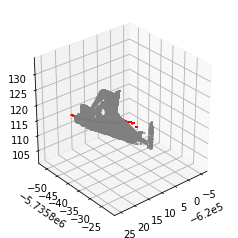

Added submap 0
Build PCL from VO with 1172 measurements...
SDK:build_pointcloud - load required data...
SDK:build_pointcloud - start building the pointcloud...
SDK:build_pointcloud - finished 1000 / 1170
Done!
Transform pointcloud to NED system...
Done!


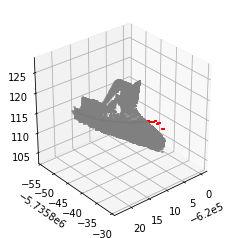

Added submap 1
End of trajectory reached


In [24]:
pcl_loader = PointcloudLoader()
pcl_loader.load_ned_trajectory(subset_split=0.01)
#pcl_loader.load_ned_pointcloud()
pcl_loader.generate_submaps(20, 1, width=40, plot=True)